# Libraries

In [1]:
import pandas as pd
from tqdm import tqdm
from sklearn.cluster import KMeans
from collections import defaultdict
from collections import Counter
import math
from ast import literal_eval
import numpy as np
import matplotlib.pyplot as plt
import random
import time

# Cleaning the Data

In [2]:
#path = '/Users/domenicomattiacinque/Documents/Università/ADM2020/HW4/archive'
dataset = pd.read_csv('Reviews.csv')
dataset.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [3]:
dataset.isnull().sum()

Id                         0
ProductId                  0
UserId                     0
ProfileName               16
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64

We can see that there are null values only in the columns `ProfileName` and `Summary`. In the next cell er are going to fill only the summary column with empty string because for our purposes we don't need the profile name that will be dropped.

In [4]:
dataset['Summary'].fillna('', inplace=True)

In order to have a better understading of the type of product we group the column summary and text together.

In [5]:
dataset['Text'] = dataset['Summary'] + ' ' + dataset['Text'] 

We drop the column that we don't need to use for this homework.

In [6]:
dataset.drop(['ProfileName','HelpfulnessNumerator',
              'HelpfulnessDenominator','Time','Summary'],axis=1, inplace=True)
dataset.head()

,Id,ProductId,UserId,Score,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,5,Good Quality Dog Food I have bought several of...
1,2,B00813GRG4,A1D87F6ZCVE5NK,1,Not as Advertised Product arrived labeled as J...
2,3,B000LQOCH0,ABXLMWJIXXAIN,4,"""Delight"" says it all This is a confection tha..."
3,4,B000UA0QIQ,A395BORC6FGVXV,2,Cough Medicine If you are looking for the secr...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,5,Great taffy Great taffy at a great price. The...


Our task is to cluster the product so we apply a groupby on `ProductId`.

In [7]:
df = dataset.groupby('ProductId')['Text'].apply(lambda x: ' '.join(x)).reset_index()
df.head()

,ProductId,Text
0,0006641040,Read it once. Read it twice. Reading Chicken S...
1,141278509X,The best drink mix This product by Archer Farm...
2,2734888454,made in china My dogs loves this chicken but i...
3,2841233731,Great recipe book for my babycook This book is...
4,7310172001,very good This product is a very health snack ...


In [8]:
df.shape

(74258, 2)

# Text Mining
We want to cluster the products using the reviews that we can find in the column `Text` of our dataset. In order to do this we need to represent the reviews as TF-IDF score used in the previous homework.

In [9]:
import nltk
from nltk.corpus import stopwords
import string
import re
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from tqdm import tqdm

In the list of stop words we insert words that don't add information about the product they are refering to.

In [22]:
stop_words = set(stopwords.words('english'))
stop_words = stop_words.union({'br','product','http','lot','time','item','everith','someone','thing','bit','anyth','thank', 'time', 'way', 'thing', 'stuff', 'really', 'taste'})
ps = PorterStemmer()

In [23]:
#Realizing the cleaned token 
def clean_text(text):
    words = word_tokenize(text)    #tokenizing the text
    tagged = nltk.pos_tag(words)   #tag help us to understand what kind of word is 
    good_words = ""                # list of cleaned words
    for word,tag in tagged:
        if tag == 'NN' or tag == 'NNS' or tag =='NNPS' or tag == 'NNP': #filter on the words
            if word.lower() not in stop_words and word.isalpha() and word.lower() not in string.punctuation:
                good_words += ps.stem(word).lower() + " "
    return good_words.strip()

In [24]:
#Cleaning the column 'Text_Words'
df['Text_Words'] = df.Text.apply(lambda x: clean_text(x))
df.head()

,ProductId,Text,Text_Words
0,0006641040,Read it once. Read it twice. Reading Chicken S...,chicken soup rice day person chicken soup word...
1,141278509X,The best drink mix This product by Archer Farm...,drink mix archer farm drink mix packet oz wate...
2,2734888454,made in china My dogs loves this chicken but i...,dog chicken china chicken product usa isnt cha...
3,2841233731,Great recipe book for my babycook This book is...,great book babycook book ingredi store recip b...
4,7310172001,very good This product is a very health snack ...,health snack pup beef liver trick treat prici ...


In [16]:
# !!! CELLA DA CANCELLARE UNA VOLTA FINITO L'HW !!!
df = pd.read_csv('new_reviews.csv')

In [47]:
df['Text_Words'].fillna('', inplace=True)
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=0.001,use_idf= True)
matrix = vectorizer.fit_transform(df['Text_Words'])
matrix.shape

(74258, 4988)

In [238]:
flat_list = [item for items in df.Text_Words for item in items.split()]
counts = pd.Series(flat_list).value_counts().sort_values(ascending = False)
counts.head(30)

flavor     201188
coffe      195153
tea        166989
food       162908
dog        123663
price       92625
bag         86793
amazon      82742
treat       73130
cat         72511
great       68599
cup         68512
day         66544
box         66226
chocol      65552
water       63724
store       63600
year        58785
brand       58507
sugar       55307
packag      50623
chip        49247
snack       48059
order       46914
review      46383
cooki       46015
bar         45524
ingredi     43756
qualiti     38938
one         38660
dtype: int64

## Dimensionality Reduction usign SVD

In order to use SVD method we need to create a sparse matrix, for this aim we use the library scipy and sklearn

In [49]:
from sklearn.decomposition import TruncatedSVD

In [52]:
svd = TruncatedSVD(n_components=450)
svd.fit(matrix)

TruncatedSVD(n_components=450)

we picked a number of components that retain about 60% of the variance

In [53]:
print(svd.explained_variance_ratio_.sum())

0.6076488254682255


In [54]:
svd_matrix = svd.transform(matrix)
svd_matrix.shape

(74258, 450)

## Implement KMeans from scratch
### Step 1
Random inizialization of the k representative points
### Step 2
Find the cluster $C_i$ defined as $\{x : \parallel x-\mu_i\parallel \leq \parallel x-\mu_j\parallel \forall j\ne i\}  \forall i=1..k$
### Step 3 
Find $\mu_i$ which is defined as $\frac{1}{|C_i|} \sum_{x\in C_i} x \;\; \forall i=1..k$
<hr>
Repeat step 2 and step 3 until <b>convergence</b>.

### Convergence
We stop when the clusters don't change from the previous iteration.

### Step 4 
Elbow method to choose the number of clusters k 

### Our KMeans

In [81]:
def euclidian_dist(x,y):
    return np.linalg.norm(x-y)

In [86]:
def OurKMeans(k, matrix, representatives_idx = []):
    
    start = time.time()
    
    if representatives_idx == []:
        representatives_idx = random.sample(range(0, len(svd_matrix)), k)
    
    # 1. Choosing k random representatives
    representatives_idx = representatives_idx[:k]
    new_representatives =  []
    for i in range(k):
        new_representatives.append(matrix[representatives_idx[i]])
    representatives = []
    
    run = True
    
    while run:
        representatives = new_representatives
        
        # Creating the clusters
        clusters = {i: [] for i in range(k)}  # Empty dictionary for each cluster with list as value 
        i_clusters = {i: [] for i in range(k)}
        
        # 2. Computing distances and choosing 
        for ind, point in enumerate(matrix):
            dist_xmu = []      # Distance between the point and the representatives for each representative
            for i in range(k): 
                dist_xmu.append(euclidian_dist(representatives[i], point))
            nearest_representative = dist_xmu.index(min(dist_xmu))
            clusters[nearest_representative].append(point) #Put the point in the cluster with the minimum distance
            i_clusters[nearest_representative].append(ind)
            
        # 3. Selecting new representatives
        new_representatives = []
        for i in range(k):
            run = False
            new_val = np.sum(clusters[i], axis=0)/len(clusters[i])
            new_representatives.append(new_val)
        
        for i in range(len(representatives)):
            if np.any(representatives[i] != new_representatives[i]):
                run = True
                
    return clusters, new_representatives, i_clusters

### Elbow Method 

The elbow method allows us to choose the number of cluster k choosing the elbow point in the plot that has the number of cluster as x axis and the inertia as y axis. <br>
First of all we implement the function that calculate the inertia which is defined as: <hr>
<center>$\sum_{i=0}^{n}\min_{\mu_j \in C}(||x_i - \mu_j||^2) $ </center>
where: <br>
- $\mu_j$ are the centroids for j in range (1,k) <br>
- $x_i$ are the points to cluster for i in range (0,n)

In [87]:
def inertia(matrix, centroid, k):
    sq_norms = [] #consideranting the norms of xi - muj where i is fixed and j is in range(k)
    sum_ = 0
    for i in range(len(matrix)):
        sq_norms = []
        for j in range(k):
            sq_norm = euclidian_dist(matrix[i],centroid[j])**2 # squared norm between xi and muj
            sq_norms.append(sq_norm) #saving the result in the j-th position of sq_norms array
        min_sq_norm = min(sq_norms) #considering the minimum norm
        sum_ += min_sq_norm
    return sum_ #return inertia

In [133]:
k = 20
representatives_idx = random.sample(range(0, len(svd_matrix)), k)  #Chosing the initial representatives

In [154]:
elbow = []
for k in tqdm(range(16, 21)):
    clusters, representatives, i_clusters = OurKMeans(k, svd_matrix, representatives_idx)
    inertia_ = inertia(svd_matrix, representatives, k) 
    elbow.append(inertia_)

100%|██████████| 5/5 [18:40<00:00, 224.10s/it]


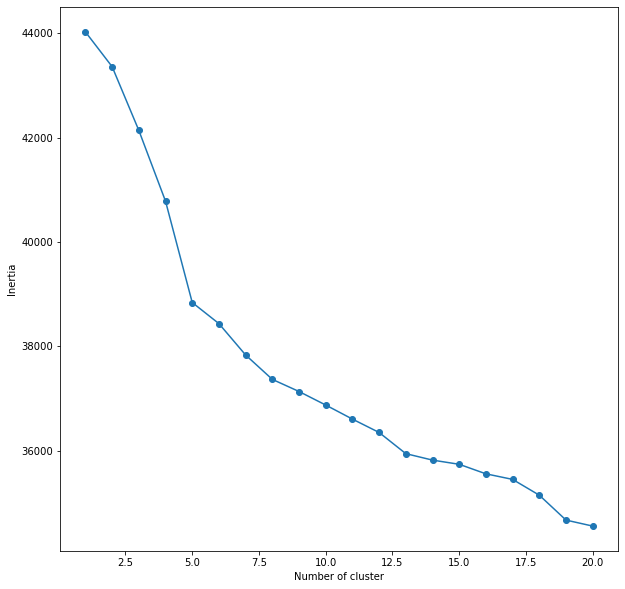

In [155]:
plt.figure(figsize = (10, 10))
plt.plot(range(1,21), elbow)
plt.scatter(range(1,21), elbow)
plt.xlabel("Number of cluster")
plt.ylabel("Inertia")
plt.show()

From the previous plot we fix k equals to 7

In [ ]:
our_KMeans = ourKMeans(7, svd_matrix)

## KMeans ++
To implement KMeans++ and the elbow method we use sklearn library

In [99]:
from sklearn.cluster import KMeans

In [116]:
elbow2 = {}
for k in tqdm(range(1,71)):
    elbow_model = KMeans (n_clusters = k, init = 'k-means++')
    elbow_model.fit_predict(svd_matrix)
    elbow2[k] = elbow_model.inertia_

100%|██████████| 2/2 [01:33<00:00, 47.00s/it]


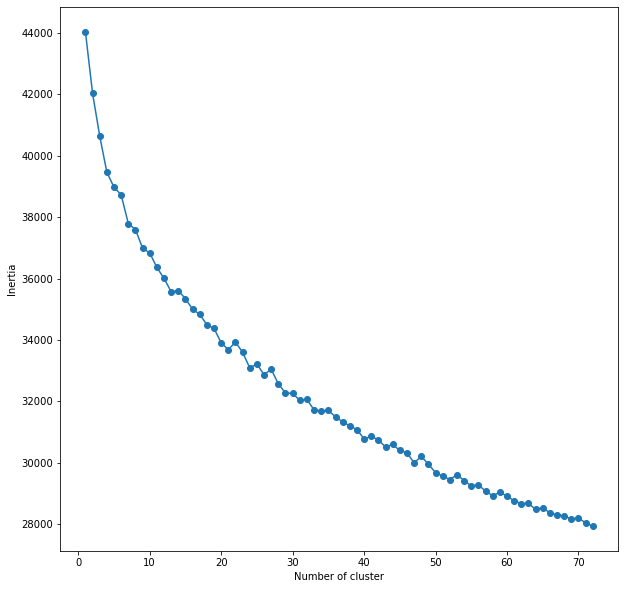

In [187]:
plt.figure(figsize=(10, 10))
plt.plot(list(elbow2.keys()), list(elbow2.values()))
plt.scatter(list(elbow2.keys()), list(elbow2.values()))
plt.xlabel("Number of cluster")
plt.ylabel("Inertia")
plt.show()

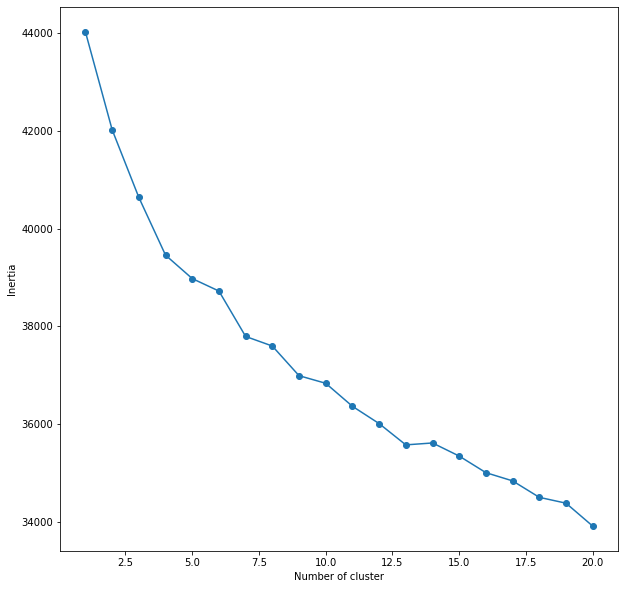

In [240]:
plt.figure(figsize=(10, 10))
plt.plot(list(elbow2.keys())[:20], list(elbow2.values())[:20])
plt.scatter(list(elbow2.keys())[:20], list(elbow2.values())[:20])
plt.xlabel("Number of cluster")
plt.ylabel("Inertia")
plt.show()

In [23]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=7, random_state=0, init='k-means++').fit(matrix)

### Comparison 

As first result we can observe that the elbow method return the same number of cluster for both the algorithms.
?cluster
?inertia
?initial centroid

## Cluster Analysis

We create another column to the dataset which contains the cluster number the record belongs to, this is a possible solution to answer at the final questions.

In [241]:
from sklearn.cluster import KMeans
import seaborn as sns

kmeans = KMeans(n_clusters=13, random_state=0, init='k-means++').fit(matrix)

In [160]:
labels = kmeans.labels_

In [161]:
df['cluster'] = labels

In [162]:
df.head()

,ProductId,Text,Text_Words,cluster
0,0006641040,Read it once. Read it twice. Reading Chicken S...,chicken soup rice day person chicken soup word...,1
1,141278509X,The best drink mix This product by Archer Farm...,drink mix archer farm drink mix packet oz wate...,1
2,2734888454,made in china My dogs loves this chicken but i...,dog chicken china chicken product usa isnt cha...,4
3,2841233731,Great recipe book for my babycook This book is...,great book babycook book ingredi store recip b...,1
4,7310172001,very good This product is a very health snack ...,health snack pup beef liver trick treat prici ...,4


### Identify the kind of products in the cluster

In [232]:
df_cluster = df.groupby('cluster')['Text_Words'].apply(lambda x: ' '.join(x)).reset_index()
df_cluster.cluster += 1

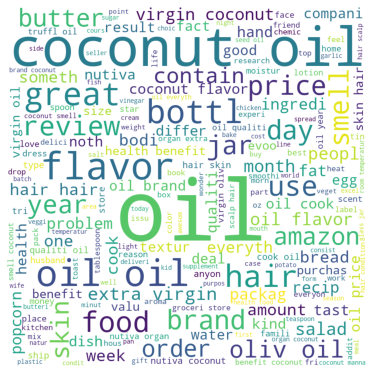

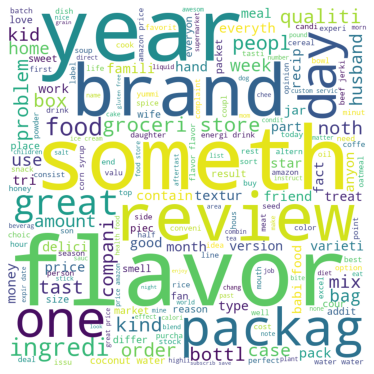

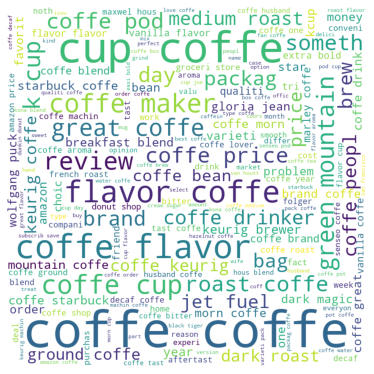

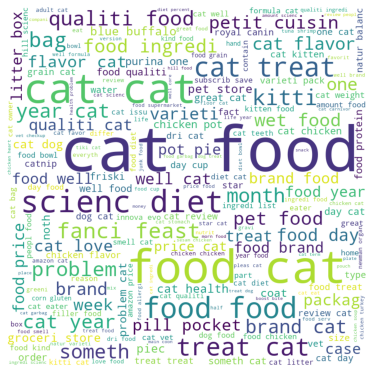

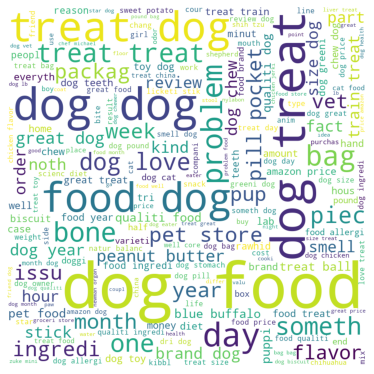

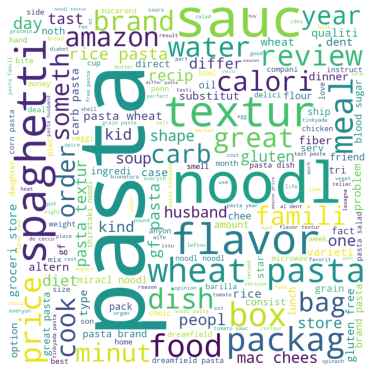

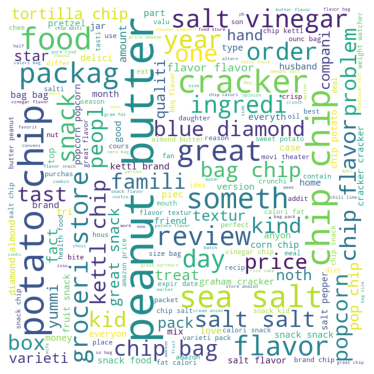

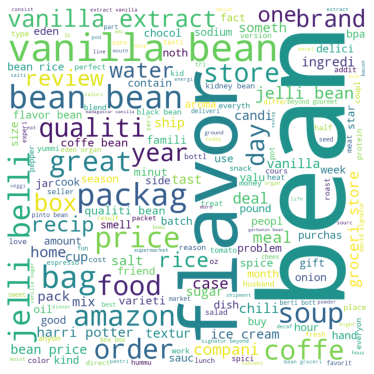

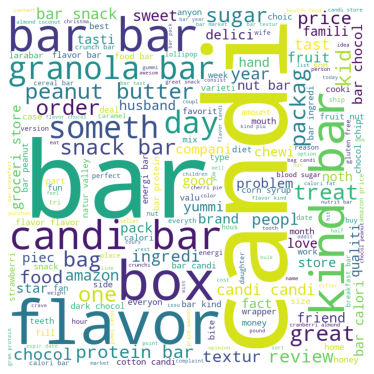

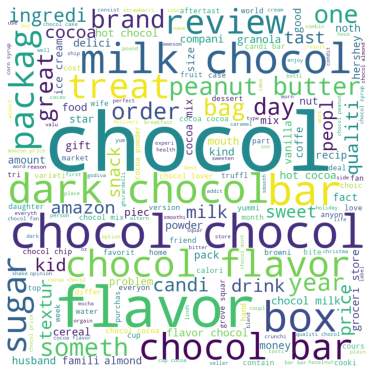

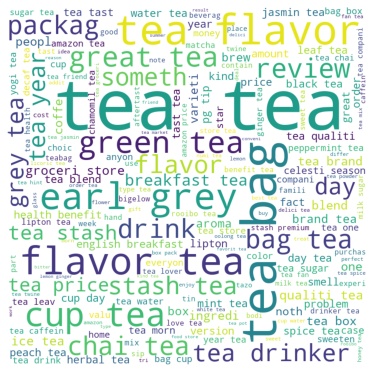

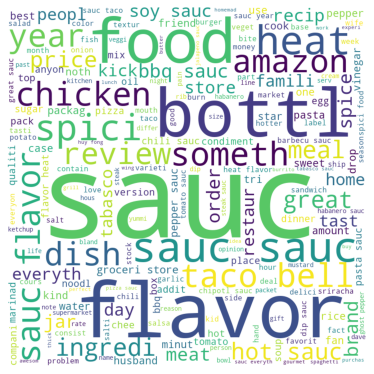

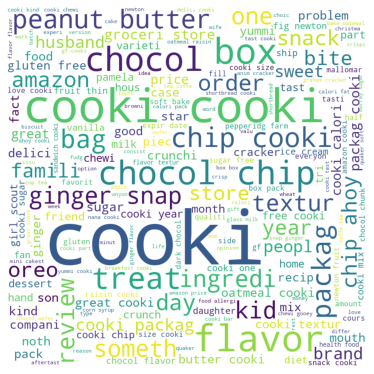

In [233]:
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 

for i in range(len(df_cluster)):
    wordcloud = WordCloud(width = 800, height = 800, 
                    background_color ='white', 
                    stopwords = stop_words, 
                    min_font_size = 10).generate(df_cluster.iloc[i].Text_Words) 

    plt.figure(figsize = (5, 5), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 

    plt.show() 

Through these plots we can suppose that the clusters contain the following product:
- Cluster 0 : is a single review that isn't about food but about eletronics
- Cluster 1 : about tea
- Cluster 2 : food basket to use as a gift
- Cluster 3 : about meat and sauces
- Cluster 4 : animal food
- Cluster 5 : salami
- Cluster 6 : coffee

### Provide the number of product in each cluster

In [213]:
df_cluster2 = df.groupby('cluster')['ProductId'].count().reset_index()
df_cluster2.cluster = df_cluster2.cluster + 1

In [214]:
df_cluster2

,cluster,ProductId
0,1,951
1,2,41554
2,3,4158
3,4,1870
4,5,4244
5,6,794
6,7,4712
7,8,944
8,9,3385
9,10,2731


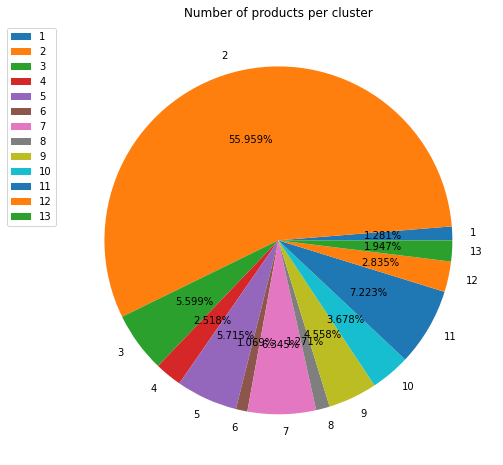

In [215]:
lab = df_cluster2['cluster']
plt.figure(figsize=(8,8))
plt.title('Number of products per cluster')
plt.pie(df_cluster2['ProductId'], labels=lab, autopct='%.3f%%')
plt.legend(bbox_to_anchor=(0,1))
plt.show()

We can observe that the product aren't equally distributed in the clusters. <br>
The majority of product are in the cluster about pet food, followed by tea and coffe. We can conclude that most of the people by on amazon these kind of product rather than dried meat and salami.

### Compute the reviews' score distribution in each cluste

In [220]:
comb = df[['ProductId','cluster']].set_index('ProductId').T.to_dict()

In [221]:
dataset['cluster'] = dataset.ProductId.apply(lambda x: comb[x]['cluster'])
dataset.cluster = dataset.cluster+1

In [222]:
dataset

,Id,ProductId,UserId,Score,Text,cluster
0,1,B001E4KFG0,A3SGXH7AUHU8GW,5,Good Quality Dog Food I have bought several of...,5
1,2,B00813GRG4,A1D87F6ZCVE5NK,1,Not as Advertised Product arrived labeled as J...,7
2,3,B000LQOCH0,ABXLMWJIXXAIN,4,"""Delight"" says it all This is a confection tha...",2
3,4,B000UA0QIQ,A395BORC6FGVXV,2,Cough Medicine If you are looking for the secr...,2
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,5,Great taffy Great taffy at a great price. The...,2
...,...,...,...,...,...,...
568449,568450,B001EO7N10,A28KG5XORO54AY,5,Will not do without Great for sesame chicken.....,2
568450,568451,B003S1WTCU,A3I8AFVPEE8KI5,2,disappointed I'm disappointed with the flavor....,10
568451,568452,B004I613EE,A121AA1GQV751Z,5,Perfect for our maltipoo These stars are small...,5
568452,568453,B004I613EE,A3IBEVCTXKNOH,5,Favorite Training and reward treat These are t...,5


In [223]:
dataset.groupby('cluster')['Score'].mean()

cluster
1     4.435818
2     4.130618
3     4.124419
4     4.187120
5     4.212268
6     4.300208
7     4.233319
8     4.247539
9     4.203659
10    4.143996
11    4.307372
12    4.314270
13    4.229007
Name: Score, dtype: float64

In [246]:
for i in range(7):
    data = dataset[dataset.cluster == i]['Score']
    
    sns.displot(data, discrete=True)
    plt.show()

AttributeError: module 'seaborn' has no attribute 'displot'

In [235]:
from scipy import stats
print('|--------------------------------------------------------|')
print('| T-Test for mean differences at 90% significance level |')
print('|--------------------------------------------------------|')
print('')
for i in range(1, 14):
    for j in range(i+1,14):
        res = round(stats.ttest_ind(dataset[dataset.cluster == i]['Score'], dataset[dataset.cluster == j]['Score'])[1],4)
        if res >= 0.10:
            print('Pvalue from test of clusters', i, 'and', str(j)+':', res ,'==> Significant!')
        else:
            print('Pvalue from test of clusters', i, 'and', str(j)+':', res ,'==> Not significant')

|--------------------------------------------------------|
| T-Test for mean differences at 90% significance level |
|--------------------------------------------------------|

Pvalue from test of clusters 1 and 2: 0.0 ==> Not significant
Pvalue from test of clusters 1 and 3: 0.0 ==> Not significant
Pvalue from test of clusters 1 and 4: 0.0 ==> Not significant
Pvalue from test of clusters 1 and 5: 0.0 ==> Not significant
Pvalue from test of clusters 1 and 6: 0.0 ==> Not significant
Pvalue from test of clusters 1 and 7: 0.0 ==> Not significant
Pvalue from test of clusters 1 and 8: 0.0 ==> Not significant
Pvalue from test of clusters 1 and 9: 0.0 ==> Not significant
Pvalue from test of clusters 1 and 10: 0.0 ==> Not significant
Pvalue from test of clusters 1 and 11: 0.0 ==> Not significant
Pvalue from test of clusters 1 and 12: 0.0 ==> Not significant
Pvalue from test of clusters 1 and 13: 0.0 ==> Not significant
Pvalue from test of clusters 2 and 3: 0.2851 ==> Significant!
Pvalue from t

### Unique users writing reviews in each cluster

In [236]:
obj = dataset.groupby('cluster')['UserId'].nunique().reset_index()

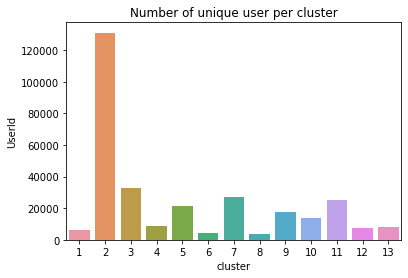

In [244]:
#sns.set_theme(style="whitegrid")
ax = sns.barplot(x="cluster", y="UserId", data=obj)
plt.title('Number of unique user per cluster')
plt.show()

In the second column we show the number of users that have written a reviews for a product in the related cluster.